In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

100%|██████████| 169001437/169001437 [00:05<00:00, 33249983.77it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.7MB/s]


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Loss: 2.6688, Training Accuracy: 0.3205
Validation Loss: 1.5890, Validation Accuracy: 0.5498
Validation Accuracy improved to 0.5498. Model saved.
Epoch 2/50
Training Loss: 1.8020, Training Accuracy: 0.5130
Validation Loss: 1.4868, Validation Accuracy: 0.5937
Validation Accuracy improved to 0.5937. Model saved.
Epoch 3/50
Training Loss: 1.5896, Training Accuracy: 0.5675
Validation Loss: 1.3752, Validation Accuracy: 0.6255
Validation Accuracy improved to 0.6255. Model saved.
Epoch 4/50
Training Loss: 1.4692, Training Accuracy: 0.5976
Validation Loss: 1.2808, Validation Accuracy: 0.6494
Validation Accuracy improved to 0.6494. Model saved.
Epoch 5/50
Training Loss: 1.3667, Training Accuracy: 0.6254
Validation Loss: 1.1474, Validation Accuracy: 0.6778
Validation Accuracy improved to 0.6778. Model saved.
Epoch 6/50
Training Loss: 1.3047, Training Accuracy: 0.6383
Validation Loss: 1.1426, Validation Accuracy: 0.6802
Validation Accuracy improved to 0.6802. Model saved.
Epoch 7/50
Trai

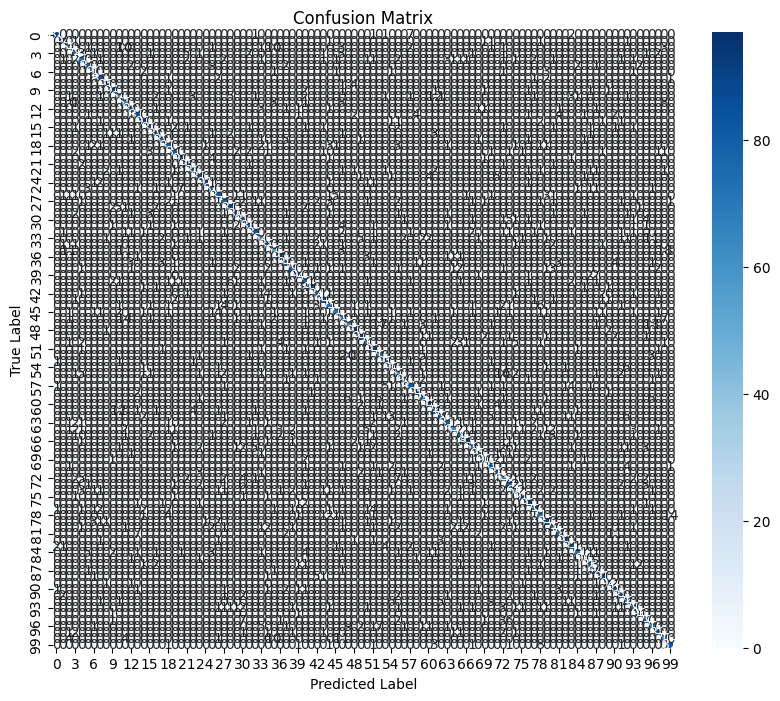

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       100
           1       0.93      0.94      0.94       100
           2       0.65      0.66      0.66       100
           3       0.78      0.78      0.78       100
           4       0.71      0.72      0.72       100
           5       0.86      0.82      0.84       100
           6       0.83      0.90      0.87       100
           7       0.87      0.87      0.87       100
           8       0.93      0.95      0.94       100
           9       0.89      0.91      0.90       100
          10       0.70      0.64      0.67       100
          11       0.59      0.65      0.62       100
          12       0.87      0.89      0.88       100
          13       0.85      0.83      0.84       100
          14       0.88      0.92      0.90       100
          15       0.87      0.86      0.86       100
          16       0.89      0.89      0.89       100
          17       0.93    

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations with enhanced augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter
    transforms.RandomRotation(15),  # Randomly rotate the image
    transforms.RandomGrayscale(p=0.1),  # Occasionally turn images to grayscale
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
train_dataset = datasets.CIFAR100(root='data', train=True, download=True, transform=train_transform)
val_dataset = datasets.CIFAR100(root='data', train=False, download=True, transform=val_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

# Define the model using ResNet50
base_model = models.resnet50(pretrained=True)
num_features = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 100)  # CIFAR-100 has 100 classes
)

# Move model to the device
model = base_model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # Use SGD with momentum
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Training function with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7):
    best_acc = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects.double() / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Learning rate scheduler step
        scheduler.step(val_acc)

        # Check for improvement in validation accuracy
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0
            print(f"Validation Accuracy improved to {val_acc:.4f}. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in Validation Accuracy. Patience counter: {patience_counter}/{patience}")

        # Check if patience has been exhausted
        if patience_counter >= patience:
            print(f"Early stopping triggered. Best Validation Accuracy: {best_acc:.4f}")
            break

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

# Train the model with early stopping
model = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=7)

# Save the best model
torch.save(model.state_dict(), 'resnet50_cifar100_best_tweaked.pth')

# Evaluate the model
def evaluate_model(model, val_loader):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(100)]))

# Evaluate the trained model
model.eval()
evaluate_model(model, val_loader)
